RuntimeError: No active exception to reraise

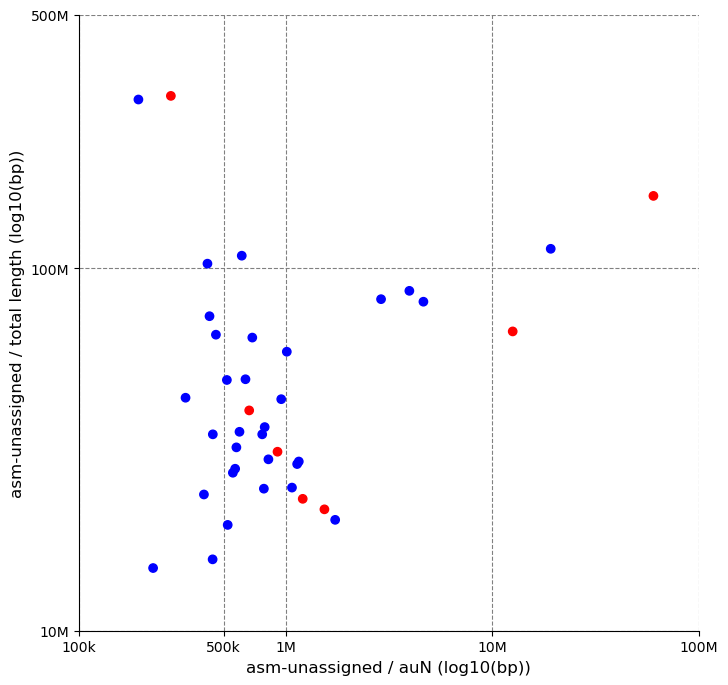

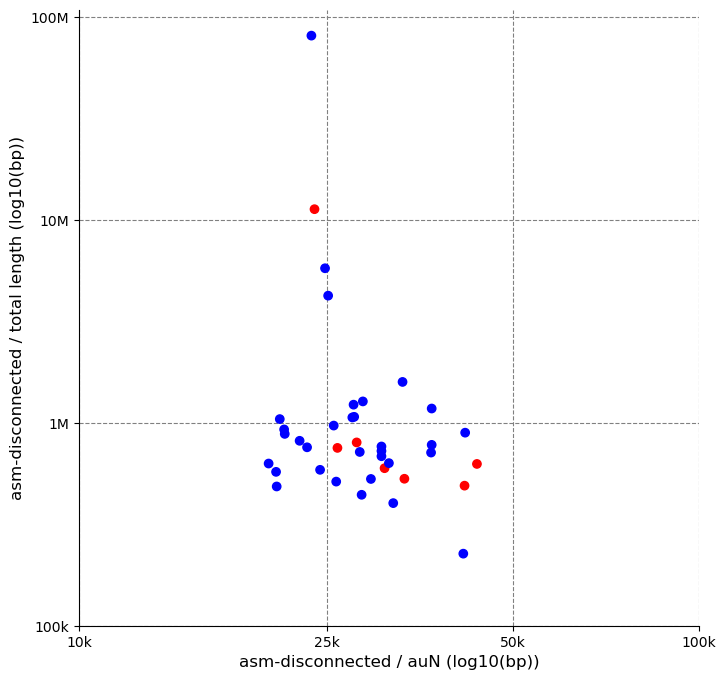

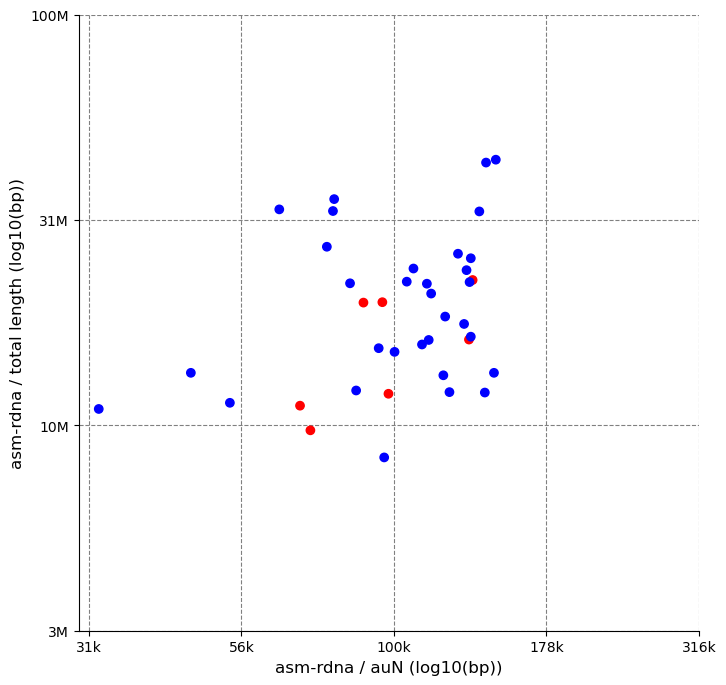

In [74]:
%run "../00_project_config.ipynb"

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib as pl
import numpy as np
import itertools as itt

batch1_stats = PROJECT_BASE.joinpath(
    "annotations", "autogen", "verkko_batch1_assemblies.tsv"
)

stats = pd.read_csv(batch1_stats, header=[0, 1], sep="\t", comment="#", index_col=[0, 1])
stats = stats.droplevel("sample_num", axis=0)

sex_lut = dict((row.sample, row.sex) for row in HGSVC_SAMPLES.itertuples())

# determine sample sort order by total contamination in sample
contam_stats = stats.xs("contaminants", level="sequence", axis=1).copy()
contam_stats.sort_values("total_length_grt_0bp", inplace=True)
total_contam_lut = dict((row.Index, row.total_length_grt_0bp) for row in contam_stats.itertuples())
sample_order_by_contam = dict((s, pos) for pos, s in enumerate(contam_stats.index.values))

# plot both haplotypes in single plot
hap1_data = stats.xs("asm-hap1", level="sequence", axis=1).copy()
hap2_data = stats.xs("asm-hap2", level="sequence", axis=1).copy()

x_pos = []
x_label_pos = []
x_sample_labels = []
plot_length = []
plot_aun = []
pos_count = 0
for hap1, hap2 in zip(hap1_data.itertuples(), hap2_data.itertuples()):
    sample_order = sample_order_by_contam[hap1.Index]
    sample_sex = sex_lut[hap1.Index]
    pos_count += 1
    x_pos.append(pos_count)
    x_label_pos.append(pos_count + 0.5)
    x_sample_labels.append((sample_order, f"{hap1.Index} ({sample_sex[0]})"))
    plot_length.append((sample_order, hap1.Index, sample_sex, "blue", 1, hap1.total_length_grt_0bp))
    plot_aun.append((sample_order, hap1.Index, sample_sex, "blue", 1, hap1.length_auN_grt_0bp))
    pos_count += 1
    x_pos.append(pos_count)
    plot_length.append((sample_order, hap1.Index, sample_sex, "orange", 2, hap2.total_length_grt_0bp))
    plot_aun.append((sample_order, hap1.Index, sample_sex, "orange", 2, hap2.length_auN_grt_0bp))
    pos_count += 1

plot_length = sorted(plot_length)
plot_aun = sorted(plot_aun)
x_sample_labels = [t[1] for t in sorted(x_sample_labels)]
assert len(plot_length) == len(x_pos)

# === plot total length and auN of haploid assembly
plot_length_heights = np.array([t[5] for t in plot_length], dtype=float)
plot_length_heights /= 1e9
plot_length_heights.round(2)

plot_length_colors = [t[3] for t in plot_length]

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(
    x_pos,
    plot_length_heights,
    color=plot_length_colors
)
ax.set_xticks(x_label_pos)
ax.set_xticklabels(x_sample_labels, fontsize=8, rotation=90)

ax.set_xlabel("Samples by contamination (low to high)", fontsize=14)
ax.set_ylabel("Haploid assembly length (Gbp)", fontsize=14)
plt.close(fig)

plot_aun_heights = np.array([t[5] for t in plot_aun], dtype=float)
plot_aun_heights /= 1e6
plot_aun_heights.round(2)
plot_aun_colors = [t[3] for t in plot_aun]

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(
    x_pos,
    plot_aun_heights,
    color=plot_aun_colors
)
ax.set_xticks(x_label_pos)
ax.set_xticklabels(x_sample_labels, fontsize=8, rotation=90)

ax.set_xlabel("Samples by contamination (low to high)", fontsize=14)
ax.set_ylabel("Haploid assembly auN (Mbp)", fontsize=14)
plt.close(fig)

# === plot scatter for rDNA, unassigned, disconnected
# total length vs auN

for asm_unit in ["asm-unassigned", "asm-disconnected", "asm-rdna"]:
    
    sub_data = stats.xs(asm_unit, level="sequence", axis=1).copy()

    x_aun_values = []
    y_len_values = []
    color_points = []
    for row in sub_data.itertuples():
        total_contam = total_contam_lut[row.Index]
        if total_contam > 1e7:
            color_points.append("red")
        else:
            color_points.append("blue")
        aun = round(np.log10(row.length_auN_grt_0bp), 3)
        total = round(np.log10(row.total_length_grt_0bp), 3)
        x_aun_values.append(aun)
        y_len_values.append(total)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(
        x_aun_values,
        y_len_values,
        color=color_points
    )
    
    ax.set_xlabel(f"{asm_unit} / auN (log10(bp))", fontsize=12)
    ax.set_ylabel(f"{asm_unit} / total length (log10(bp))", fontsize=12)
    
    if asm_unit == "asm-unassigned":
        ax.set_xticks([5, 5.7, 6, 7, 8])
        ax.set_xticklabels(["100k", "500k", "1M" , "10M", "100M"], fontsize=10)
        
        ax.set_yticks([7, 8, 8.7])
        ax.set_yticklabels(["10M", "100M", "500M"], fontsize=10)
        
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        
    if asm_unit == "asm-disconnected":
        ax.set_xticks([4, 4.4, 4.7, 5])
        ax.set_xticklabels(["10k", "25k", "50k", "100k"], fontsize=10)
        
        ax.set_yticks([5, 6, 7, 8])
        ax.set_yticklabels(["100k", "1M" , "10M", "100M"], fontsize=10)
        
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        
    if asm_unit == "asm-rdna":
        ax.set_xticks([4.5, 4.75, 5, 5.25, 5.5])
        ax.set_xticklabels(["31k", "56k", "100k", "178k", "316k"], fontsize=10)
        
        ax.set_yticks([6.5, 7, 7.5, 8])
        ax.set_yticklabels(["3M", "10M" , "31M", "100M"], fontsize=10)
        
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
raise


select_unit = stats["assembly_unit"] == "unassigned"
select_stat = stats["statistic"] == "total_length_grt_0bp"
select_unps = stats.loc[select_unit & select_stat, "value"] < int(1e8)
select_samples1 = set(stats.loc[select_unps.index[select_unps], "sample"].values)

select_unit = stats["assembly_unit"] == "disconnected"
select_stat = stats["statistic"] == "total_length_grt_0bp"
select_disc = stats.loc[select_unit & select_stat, "value"] < int(1e7)
select_samples2 = set(stats.loc[select_disc.index[select_disc], "sample"].values)

select_sub = select_samples1.intersection(select_samples2)

#print(stats.loc[(stats["sample"].isin(select_sub)) & (stats["sex"] == "female"), "sample"].unique())

#raise

select_stat1 = stats["statistic"] == "length_auN_grt_0bp"
select_stat2 = stats["statistic"] == "total_num_grt_0bp"
select_stat3 = stats["statistic"] == "total_length_grt_0bp"
select_sex = stats["sex"] == "female"
select_unit = stats["assembly_unit"] == "disconnected"
selector = select_stat3 & select_sex & select_unit

print(stats.loc[selector, :])
raise

statistic = ["length_auN_grt_0bp", "total_num_grt_0bp", "total_length_grt_0bp"]
stat_labels = {
    "length_auN_grt_0bp": "auN",
    "total_num_grt_0bp": "#seq",
    "total_length_grt_0bp": "length"
}
asm_units = ["asm-hap1", "asm-hap2", "unassigned", "disconnected", "rdna"]
au_labels = {
    "asm-hap1": "hap1",
    "asm-hap2": "hap2",
    "unassigned": "unps",
    "disconnected": "single",
    "rdna": "rDNA"
}
for s in statistic:
    stat_label = stat_labels[s]
    
    plot_large = []
    plot_small = []
    
    large_labels = []
    small_labels = []
    y_unit_large = None
    y_unit_small = None
    for sex, infos in stats.groupby("sex"):
        
        for au in asm_units:
            au_label = au_labels[au]
            num_samples = infos["sample"].nunique()
            label = f"{stat_label}\n{au_label}\n{sex}\n(n={num_samples})"
            select_stat = infos["statistic"] == s
            select_au = infos["assembly_unit"] == au
            rows = select_stat & select_au
            assert rows.any()
            data = infos.loc[rows, "value"].values
            
            if au_label in ["hap1", "hap2", "unps"]:
                
                if "seq" in stat_label:
                    y_unit_large = "N"
                elif data.max() > 1e6:
                    data /= 1e6
                    y_unit_large = "Mbp"
                else:
                    y_unit_large = "bp"
                    
                plot_large.append(data)
                large_labels.append(label)
                
            else:
                
                if "seq" in stat_label:
                    y_unit_small = "N"
                elif data.max() > 1e6:
                    data /= 1e6
                    y_unit_small = "Mbp"
                elif data.min() > 1e3:
                    data /= 1e3
                    y_unit_small = "kbp"
                else:
                    y_unit_small = "bp"

                plot_small.append(data)
                small_labels.append(label)
                
    fig, ax = plt.subplots(figsize=(8,8))
    ax.boxplot(
        plot_large,
        labels=large_labels
    )
    ax.set_ylabel(f"{y_unit_large}", fontsize=14)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.boxplot(
        plot_small,
        labels=small_labels
    )
    ax.set_ylabel(f"{y_unit_small}", fontsize=14)

    
            
        
        
        